---
format:
  html:
    code-fold: false
---

## Dynamic fracture

In this notebook, we will solve the case when the crack propagation is no longer quasi-static, but dynamic. A dynamic crack propagation means that we can no longer neglect the inertial terms in the equations of motion.


Let us start by importing the necessary libraries and modules.

In [ ]:
#| code-fold: true

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from femsolver.utils import auto_vmap
from femsolver import sparse
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors
from petsc4py import PETSc
import sparsejac


from typing import Callable, Optional, Tuple

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc


### Griffith's critical length

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.


For a specimen stretched by a prestrain $\epsilon$, the applied stress at infinity is given by:

$$\sigma_{\infty} = \epsilon /E_\text{eff}$$

In [4]:
prestrain = 0.1
nu = 0.35

E = 106e3 # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15 # J/m^2
sigma_c = 20e3 # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")


mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.0051332024864342955 m


In [5]:
#| code-fold: true

def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

In [6]:
Nx = 20  # Number of elements in X
Ny = 2  # Number of elements in Y
Lx = 50*L_G  # Length in X
Ly = 4*L_G  # Length in Y

crack_length = 5*L_G

# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > crack_length)


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, -1e-6), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))
lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

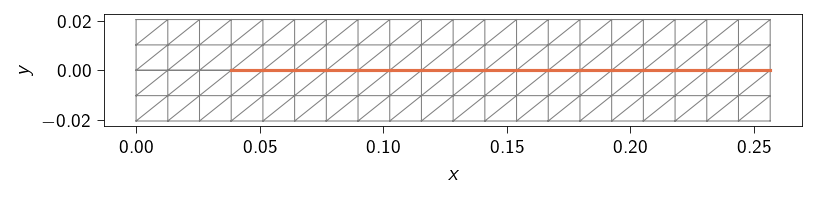

In [7]:
#| code-fold: true
#| fig-cap: "Mesh with cohesive interface"
#| fig-align: center

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], colors.red, lw=1.5)
for edge in lower_elements_1d:
    ax.plot(lower_coords[edge, 0], lower_coords[edge, 1], colors.red, lw=1.5)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect("equal")
plt.show()

To check that the elements along the cohesive line are in same order on both surface, we compare the node values for the two. 

In [8]:
jnp.allclose(coords[upper_elements_1d], coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

In [9]:
# --- Mesh ---
n_nodes = upper_coords.shape[0]
n_nodes += lower_coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

## Defining the elastic energy density

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [10]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient


mat = Material(mu=mu, lmbda=lmbda)

In [11]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


In [12]:
tri = element.Tri3()
mesh = Mesh(coords, elements)

op = Operator(mesh, tri)

In [13]:
@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

## Defining the fracture energy


The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where 

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the energy-separation relationship. 

We define a new `Line` element to integrate the cohesive energy. The `Line` element is a 1D element that is used to integrate the cohesive energy across the cohesive interface. 

In [14]:
#| code-fold: true
def generate_interface_mesh(mesh, line_elements):
    """Generate a mesh for the interface between two materials."""
    
    # --- Interface mesh ---
    line_element_nodes = jnp.unique(line_elements.flatten())
    interface_coords = mesh.coords[line_element_nodes]
    interface_elements = jnp.array([[index, index + 1] for index in range(len(line_elements))])

    interface_mesh = Mesh(interface_coords, interface_elements)
    return interface_mesh
    

In [15]:
line = element.Line2()
interface_mesh = generate_interface_mesh(mesh, lower_elements_1d)
line_op = Operator(interface_mesh, line)


In [16]:
lower_cohesive_nodes = jnp.unique(lower_elements_1d.flatten())
upper_cohesive_nodes = jnp.unique(upper_elements_1d.flatten())
print(lower_cohesive_nodes)
print(upper_cohesive_nodes)

[ 74  77  80  83  86  89  92  95  98 101 104 107 110 113 116 119 122 125]
[ 9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60]


In [17]:
class CohesiveMaterial(NamedTuple):
    """Material properties for the elasticity operator."""

    Gamma: float  # Fracture energy
    sigma_c: float  # Critical stress
    penalty: float  # Penalty parameter


cohesive_mat = CohesiveMaterial(Gamma=Gamma, sigma_c=sigma_c, penalty=1e8)

We now define function to compute the cohesive energy for a point along the interface. Using the `line_op` operator, we can than decorate the function with the `integrate` decorator to compute the energy along the interface.

In [18]:
def safe_sqrt(x):
    return jnp.sqrt(jnp.where(x > 0., x, 0.))

@auto_vmap(jump=1)
def compute_opening(jump: jnp.ndarray) -> float:
    opening = safe_sqrt(jump[0] ** 2 + jump[1] ** 2)
    return opening


@auto_vmap(jump=1)
def exponential_cohesive_energy(
    jump: jnp.ndarray,
    Gamma: float,
    sigma_c: float,
    penalty: float,
    delta_threshold: float = 1e-6,
) -> float:
    delta = compute_opening(jump)
    delta_c = (Gamma * jnp.exp(-1)) / sigma_c

    def true_fun(delta):
        return Gamma * (1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c)))

    def false_fun(delta):
        return 0.5 * penalty * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


# notice the operator here is line_op
@line_op.integrate
def total_cohesive_energy(u: jnp.ndarray, u_grad: jnp.ndarray, *_) -> float:
    return exponential_cohesive_energy(
        u, cohesive_mat.Gamma, cohesive_mat.sigma_c, cohesive_mat.penalty
    )

## Defining the total energy

Finally, we can put everything together to compute the total energy. The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$


In [19]:
def total_energy(u_flat: jnp.ndarray) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    elastic_strain_energy = total_strain_energy(u)

    jump = u.at[upper_cohesive_nodes, :].get() - u.at[lower_cohesive_nodes, :].get()
    cohesive_energy = total_cohesive_energy(jump)
    return elastic_strain_energy + cohesive_energy

Now lets us use the function defined above to compute the total energy of the system. This is just to check that there is no implementation error in the way we coded the functions above.

In [20]:
u = jnp.zeros(n_dofs)
total_energy(u)

Array(0., dtype=float64)

Ok, great the total energy function works. Now lets us solve the dynamic fracture problem.

## Applying Boundary Conditions

We now locate the dofs in the two domains to apply boundary conditions.

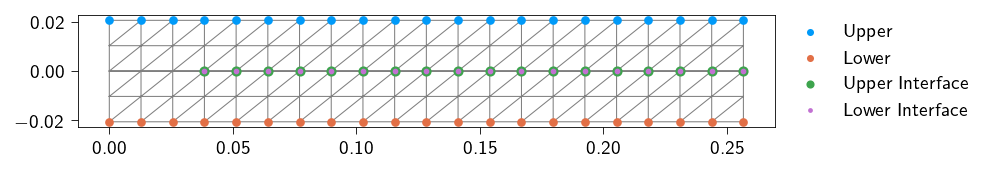

In [21]:
#| code-fold: true
#| fig-cap: "Mesh with nodes and cohesive interface"
#| fig-align: center

# --- Apply Dirichlet BCs ---
y_max = jnp.max(coords[:, 1])
y_min = jnp.min(coords[:, 1])

y_min_upper_body = jnp.min(upper_coords[:, 1])
y_max_lower_body = jnp.max(lower_coords[:, 1])

# left_upper_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] >= 0))[0]
# left_lower_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] < 0))[0]
upper_nodes = jnp.where(jnp.isclose(coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(coords[:, 1], y_min))[0]
upper_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_min_upper_body) & (coords[:, 0] > crack_length)
)[0]
lower_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_max_lower_body) & (coords[:, 0] > crack_length)
)[0]


# --- Plot the mesh ---
# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

ax.scatter(coords[upper_nodes, 0], coords[upper_nodes, 1], s=10, label="Upper")
ax.scatter(coords[lower_nodes, 0], coords[lower_nodes, 1], s=10, label="Lower")
ax.scatter(
    coords[upper_interface_nodes, 0],
    coords[upper_interface_nodes, 1],
    s=15,
    label="Upper Interface",
)
ax.scatter(
    coords[lower_interface_nodes, 0],
    coords[lower_interface_nodes, 1],
    s=3,
    label="Lower Interface",
)
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5), frameon=False)
plt.show()

In [29]:
fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
        2 * upper_interface_nodes + 1,
        2 * lower_interface_nodes + 1,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)



applied_disp = prestrain * Ly

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp/2.)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp/2.)
prescribed_values = prescribed_values.at[2 * upper_interface_nodes + 1].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_interface_nodes + 1].set(0.0)

## Constructing the sparsity pattern 

Now, we can construct the sparsity pattern for the linear system of equations. We will use the `sparse.sparsity_pattern` function to construct the sparsity pattern. This time we will have additional positions in the stiffness matrix that will correspond to the constraint on the displacement of the nodes along the cohesive interface.

In [30]:
@auto_vmap(lower_element=1, upper_element=1)
def create_cohesive_elements(lower_element, upper_element):
    return jnp.array([lower_element[0], lower_element[1], upper_element[1], upper_element[0]])


cohesive_elements = create_cohesive_elements(lower_elements_1d, upper_elements_1d)

sparsity_pattern = sparse.create_sparsity_pattern(
    elements, n_dofs_per_node, (n_dofs, n_dofs), cohesive_elements
)

We can see how the cohesive constraints along the interface leads to additional non-zero entries in the stiffness matrix. The additional non-zero entries are highlighted in red in the figure below.

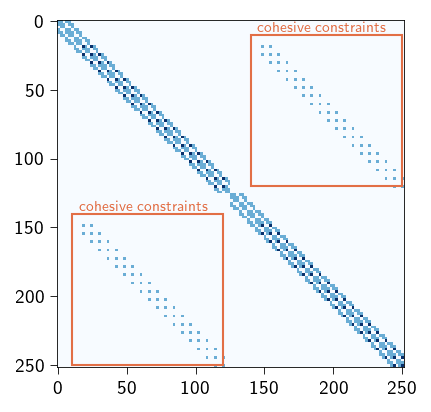

In [31]:
#| code-fold: true
#| fig-cap: "Sparsity pattern for system with cohesive interface"
#| fig-align: center
import matplotlib.patches as patches

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3,3))
ax = plt.axes()
ax.imshow(sparsity_pattern.todense(), interpolation="none", cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((10, 140), 110, 110, linewidth=1, edgecolor=colors.red, facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
rect2 = patches.Rectangle((140, 10), 110, 110, linewidth=1, edgecolor=colors.red, facecolor='none')
ax.add_patch(rect2)
ax.text(15, 138, "cohesive constraints", fontsize=7, color=colors.red)
ax.text(145, 8, "cohesive constraints", fontsize=7, color=colors.red)

plt.show()

In [32]:
gradient = jax.jacrev(total_energy)
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

In [33]:
zero_indices, one_indices = sparse.get_bc_indices(
    sparsity_pattern.indices, fixed_dofs
)

In [44]:
# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fixed_dofs,
    u_target_flat,
    n_steps,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps  # displacement increment
    u = jnp.zeros(n_nodes * n_dofs_per_node)
    fext = jnp.zeros(n_nodes * n_dofs_per_node)

    A = PETSc.Mat()
    A.createAIJ(size=(n_dofs, n_dofs))

    b = A.createVecLeft()
    du = A.createVecRight()

    errors = []

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

        fint = gradient(u)
        K_sparse = hessian_sparse(u)

        iiter = 0
        norm_res = 1.0

        while norm_res > tol and iiter < max_iter:
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            K_sparse_bc = K_sparse.data.at[zero_indices].set(0)
            K_sparse_bc = K_sparse_bc.at[one_indices].set(1)

            A.zeroEntries()
            for index, value in zip(sparsity_pattern.indices, K_sparse_bc):
                row, col = index
                A.setValue(row, col, value)
            A.assemble()

            ksp = PETSc.KSP().create()
            ksp.setOperators(A)

            b.zeroEntries()
            b.setArray(residual)

            ksp.setConvergenceHistory()
            ksp.getPC().setType("none")
            du.zeroEntries()
            ksp.solve(b, du)

            ksp.destroy()

            u = u.at[:].add(du.getArray())

            fint = gradient(u)
            K_sparse = hessian_sparse(u)

            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            norm_res = jnp.linalg.norm(du.getArray())
            print(f"  Residual: {jnp.linalg.norm(residual):.2e}")
            print(f"  du: {jnp.linalg.norm(du.getArray()):.2e}")

            iiter += 1

        errors.append(norm_res)

    return u.reshape(-1, n_dofs_per_node), errors

In [46]:
#| output: false


u_solution, errors = newton_solver(
    fixed_dofs=fixed_dofs,
    u_target_flat=prescribed_values,
    n_steps=20,
    tol=1e-6,
    max_iter=30,
)

Step 1/20
  Residual: 2.29e+01
  du: 2.58e-04
  Residual: 4.52e-01
  du: 9.21e-06
  Residual: 3.80e-06
  du: 6.51e-07
Step 2/20
  Residual: 6.08e-04
  du: 2.58e-04
  Residual: 5.56e-09
  du: 2.62e-08
Step 3/20
  Residual: 1.56e+00
  du: 2.58e-04
  Residual: 8.43e-01
  du: 9.15e-07
Step 4/20
  Residual: 2.08e+00
  du: 2.58e-04
  Residual: 2.14e+00
  du: 1.22e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  du: 1.07e-06
  Residual: 2.58e+00
  du: 1.07e-06
  Residual: 2.14e+00
  d

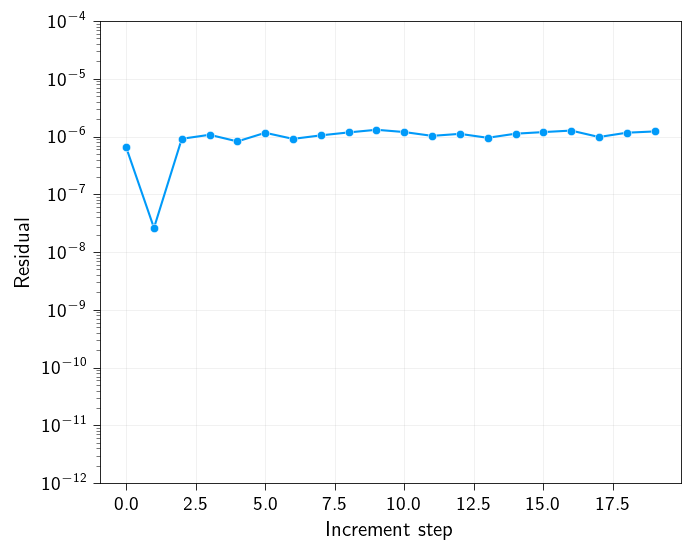

In [47]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 4))
plt.semilogy(errors, marker="o")
plt.xlabel("Increment step")
plt.ylabel("Residual")
plt.ylim(1e-12, 1e-4)
plt.grid(True)
plt.show()

We now plot the displacement fields and the stress fields within the domain. 

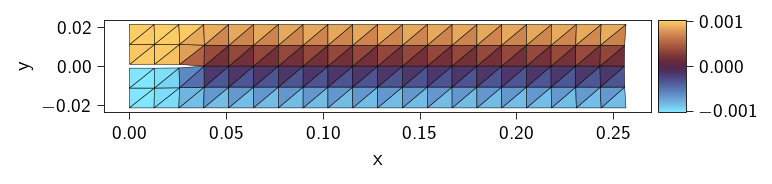

In [48]:
#| code-fold: true
#| fig-align: center


from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_nodal_values(u, mesh, nodal_values, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        nodal_values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

plot_nodal_values(
    u_solution,
    mesh,
    nodal_values=u_solution[:, 1].flatten(),
)

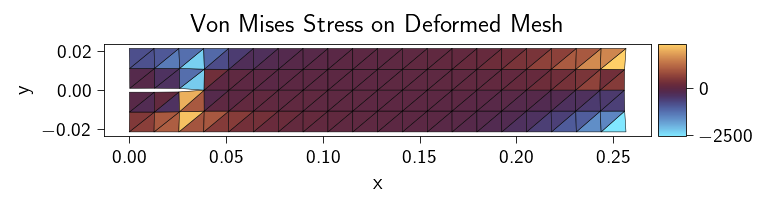

In [49]:
#| code-fold: true  
#| fig-align: center

from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_element_values(u, mesh, values, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

plot_element_values(u_solution, mesh, stresses[:, 0, 1].flatten())

## PETSc solver

In [50]:
u_lower_bounds = jnp.full(n_dofs, -jnp.inf)
u_upper_bounds = jnp.full(n_dofs, jnp.inf)

u_lower_bounds = u_lower_bounds.at[:].set(prescribed_values)
u_lower_bounds = u_lower_bounds.at[free_dofs].set(-jnp.inf)
u_upper_bounds = u_upper_bounds.at[:].set(prescribed_values)
u_upper_bounds = u_upper_bounds.at[free_dofs].set(jnp.inf)

In [56]:

class JAXMatMult:
    def __init__(self, gradient: Callable):
        self.x_cur = None
        self.gradient = gradient

    def set_x(self, x: Array):
        """Set the current iterate for the Jacobian-vector product."""
        self.x_cur = x

    def mult(self, A, X, F):
        """Set dF = J(x) * dx"""
        dx = X.getArray(readonly=True)
        tangent = jax.jvp(self.gradient, (self.x_cur,), (dx,))[1]
        F[:] = tangent


class ElasticityProblem:
    def __init__(self, func):
        self.gradient = func
        self.ctx = JAXMatMult(func)

    def set_sol(self, sol):
        self.sol_cur = sol

    def function(self, snes, X, F):
        print(X.getArray(readonly=True))
        x = jnp.array(X.getArray(readonly=True))
        f = self.gradient(x)
        F[:] = f

    def jacobian(self, snes, X, J, P):
        #self.ctx.set_x(X.getArray(readonly=True))
        return True

In [57]:
gradient = jax.jacrev(total_energy)
problem = ElasticityProblem(gradient)

In [61]:

snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(n_dofs)
J = PETSc.Mat().createPython(
    [n_dofs, n_dofs], comm=PETSc.COMM_SELF, context=problem.ctx
)
J.setUp()


alpha_lb = f.duplicate()
alpha_ub = f.duplicate()
alpha_lb.setArray(u_lower_bounds.reshape(-1))
alpha_ub.setArray(u_upper_bounds.reshape(-1))

snes.setFunction(problem.function, f)
snes.setJacobian(problem.jacobian, J, J)
snes.setType("vinewtonrsls")
snes.setVariableBounds(alpha_lb, alpha_ub)
snes.setTolerances(atol=1e-8, rtol=1e-8, max_it=20)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)

convergence_history = []
snes.setMonitor(lambda _snes, its, norm: convergence_history.append(norm))

# using matrix-free method to solve the linear system
ksp =snes.getKSP()
ksp.setType("cg")
ksp.setTolerances(rtol=1e-6, atol=1e-6)
ksp.setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)
b, alpha = None, f.duplicate()


alpha.setArray(u.reshape(-1))  # zero inital guess
snes.solve(b, alpha)
print(snes.getConvergedReason())

u_solution = alpha.getArray().reshape((n_nodes, n_dofs_per_node))
_ = snes.destroy()

[ 0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0.          0.00102664
  0.          0.          0.          0.          0

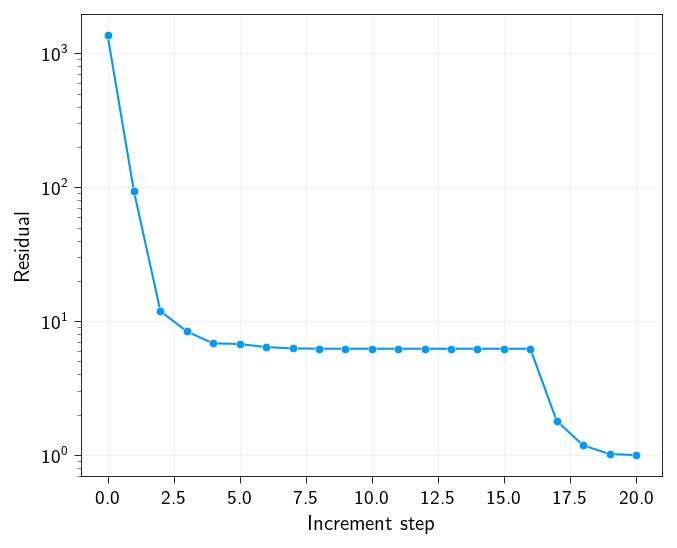

In [62]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 4))
plt.semilogy(convergence_history, marker="o")
plt.xlabel("Increment step")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

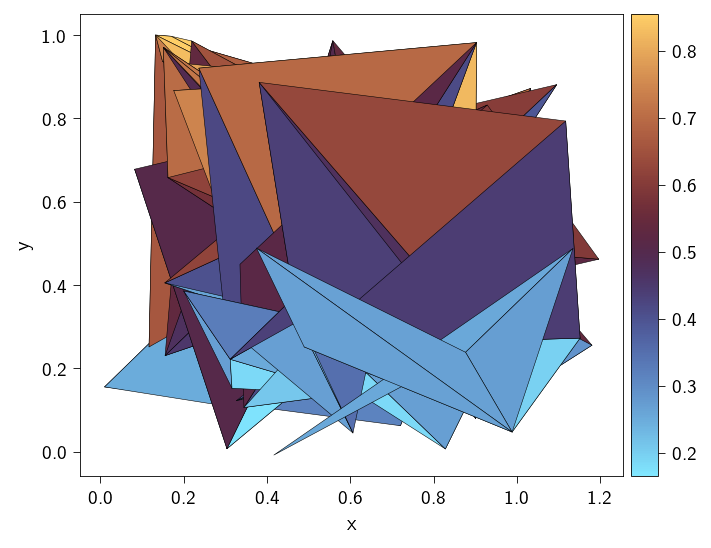

In [67]:
plot_nodal_values(
    u_solution,
    mesh,
    nodal_values=u_solution[:, 1].flatten(),
)

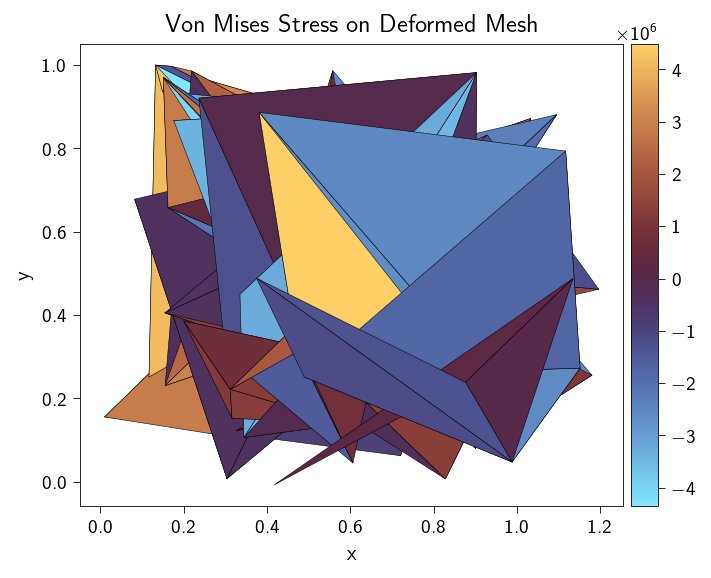

In [68]:

# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

plot_element_values(u_solution, mesh, stresses[:, 0, 1].flatten())

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

## Dynamic fracture

Now, we will solve the dynamic fracture problem. We will use the explicit time integration scheme to solve the problem.


The governing equation for the dynamic fracture problem is given as

$$
\rho \frac{\partial^2 u}{\partial t^2} - \nabla \cdot \sigma = f_{ext}
$$

where $\rho$ is the density, $u$ is the displacement, $\sigma$ is the stress, $f_{ext}$ is the external force, and $f$ is the internal force.



### Assembling mass matrix

The total mass of the system is given as
$$
m = \int \rho  dV
$$


In [63]:
rho = 1.0

class MassOperator(Operator):
    element: Element

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(xi, nodal_values, nodes)
        rho = 1.0
        return wi * rho * u_quad * detJ

NameError: name 'Element' is not defined

In [116]:
mass_op = MassOperator(element=tri3)

In [117]:
def total_mass(
    nodal_values_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    mass_op: Operator,
):
    nodal_values = nodal_values_flat.reshape(-1, n_dofs_per_node)
    return jnp.sum(mass_op.integrate(nodal_values[elements], coords[elements]))

In [118]:
ones = jnp.ones(n_dofs) 
mass_vector = jax.jacrev(total_mass)(ones, coords, elements, mass_op)

### Explicit time integration scheme

We present the explicit time integration scheme based on the Newmark-$\beta$ method.








**Predictor**

$$
u^{0}_{n+1} = u_{n} + \Delta t \dot{u}_{n} + \frac{1}{2} \Delta t^2  \ddot{u}_{n}
$$

$$
\dot{u}^{0}_{n+1} = \dot{u}_{n} + \Delta t \ddot{u}_{n}
$$

$$
\ddot{u}^{0}_{n+1} = \ddot{u}_{n}
$$


**Solve**

$$
\delta \ddot{u} = \frac{1}{\boldsymbol{M}} (f_{\text{ext}, n+1} - f_{\text{int}}(u_{n+1}^{i}) - \boldsymbol{M}\ddot{u}^{i}_{n+1})
$$




**Corrector**

$$
\ddot{u}^{i+1}_{n+1} = \ddot{u}^{i}_{n+1} + \delta\ddot{u}
$$

$$
\dot{u}^{i+1}_{n+1} = \dot{u}^{i}_{n+1} + \frac{1}{2} \Delta t  \delta \ddot{u}^{i+1}_{n+1}
$$




In [119]:
def predictor(u, v, a, dt):
    u_pred = u + dt * v + 0.5 * dt**2 * a
    v_pred = v + dt * a
    a_pred = a
    return u_pred, v_pred, a_pred

def corrector(u_pred, v_pred, a_pred, da, dt):
    a_new = a_pred + da
    v_new = v_pred + 0.5 * dt * da
    return u_pred, v_new, a_new


The explicit time integration is conditionally stable. The critical time step is given by:

$$
\Delta t \leq \frac{h}{c}
$$

where $h$ is the minimum element size and $c$ is the wave speed.

The wave speed is given by:

$$ 
c = \sqrt{\frac{\mu + \lambda}{\rho}}
$$

where $\mu$ and $\lambda$ are the Lame parameters and $\rho$ is the density.

The minimum element size is the radius of the inscribed circle of the element. Below we define a function to compute the radius of the inscribed circle of the element.


In [120]:
@auto_vmap(coords=2)
def get_inscribed_circle_radius(coords):
    c1, c2, c3 = coords
    a = jnp.linalg.norm(c2 - c1)
    b = jnp.linalg.norm(c3 - c2)
    c = jnp.linalg.norm(c1 - c3)
    s = (a + b + c) / 2
    area = jnp.sqrt(s * (s - a) * (s - b) * (s - c))
    return area / s / 2


In [121]:
h_min = jnp.min(get_inscribed_circle_radius(coords[elements]))
dt = 0.05 * h_min / (jnp.sqrt((2 * elasticity_op.mu + elasticity_op.lmbda) / rho))

print(f"critical time step: {dt}")

critical time step: 4.039869723525841e-06


Now, we can use the explicit time integration to solve the dynamic fracture problem. The initial conditions are given by the static solution.

In [122]:

boundary_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
    ]
)

In [123]:
n_steps = 2

u_dynamic = u_static.flatten()
v_dynamic = jnp.zeros_like(u_dynamic)
a_dynamic = jnp.zeros_like(u_dynamic)

f_ext = jnp.zeros_like(u_dynamic)

for step in range(n_steps):

    u_dynamic = u_dynamic.at[boundary_dofs].set(prescribed_values.at[boundary_dofs].get())
    
    u_pred, v_pred, a_pred = predictor(u_dynamic, v_dynamic, a_dynamic, dt)

    residual = f_ext - gradient(u_pred)

    residual = residual.at[boundary_dofs].set(0)
    da = residual / mass_vector  -  mass_vector * a_dynamic

    
    u_dynamic, v_dynamic, a_dynamic = corrector(u_pred, v_pred, a_pred, da, dt)
    

In [124]:

def plot_nodal_values(coords, u, elements, nodal_values, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        nodal_values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

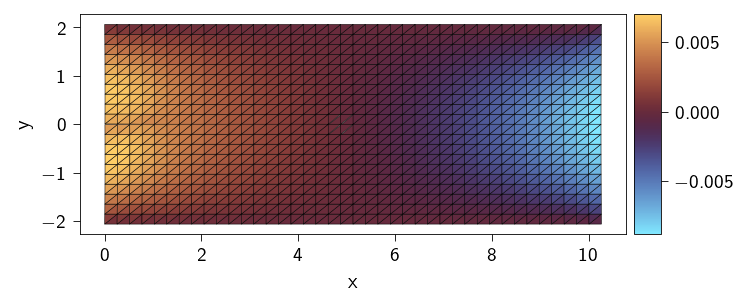

In [125]:
plot_nodal_values(
    coords,
    u_dynamic.reshape(-1, n_dofs_per_node),
    elements,
    nodal_values=u_dynamic.reshape(-1, n_dofs_per_node)[:, 0].flatten(),
)

In [126]:
@eqx.filter_vmap(in_axes=(0, 0))
def compute_quadrature_openings(nodal_values, nodes):
    qi, w = line2.get_quadrature()
  
    def quadrature_values(xi):
        jump_quad, jump_grad, detJ = line2.get_local_values(xi, nodal_values, nodes)
        
        #opening_quad = compute_opening(jump_quad, nodes)
        return jump_quad[1]

    return jax.vmap(quadrature_values)(qi)


@eqx.filter_vmap(in_axes=(0))
def compute_quadrature_points(nodes):
    qi, w = line2.get_quadrature()

    def quadrature_values(xi):
        u_quad, u_grad, detJ = line2.get_local_values(xi, nodes, nodes)
        return u_quad

    return jax.vmap(quadrature_values)(qi)

In [127]:
u = u_dynamic.reshape(-1, n_dofs_per_node)
u_upper = u[upper_elements_1d]
u_lower = u[lower_elements_1d]
# we compute the jump in the displacement field across the cohesive interface
jump_values = u_upper - u_lower
# since the two interfaces are identical, we can use the coordinates of the upper interface
# to intergate and compute the fracture energy
x_upper_cell = coords[upper_elements_1d]

quadrature_points_interface = compute_quadrature_points(x_upper_cell)[:, :, 0].flatten()

In [128]:
quadrature_openings_interface = compute_quadrature_openings(jump_values, x_upper_cell).flatten()

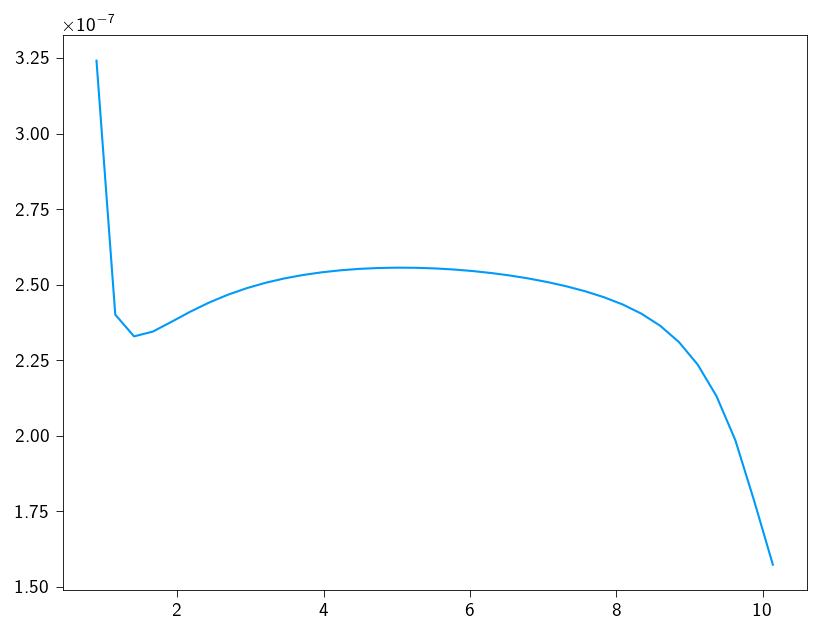

In [129]:
plt.plot(quadrature_points_interface, quadrature_openings_interface)
plt.show()